In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import torch
import os
import pickle
import itk
import nibabel as nib
from matplotlib.colors import LinearSegmentedColormap

In [11]:
input_path = '/disk1/pytomography_paper_data/input'
output_path = '/disk1/pytomography_paper_data/output'

In [13]:
hc_recon = np.load(os.path.join(output_path, 'pet_gate_experiment', 'pet_recon1.npy'))
lc_recon = np.load(os.path.join(output_path, 'pet_gate_experiment', 'pet_recon2.npy'))
dip_recon = np.load(os.path.join(output_path, 'pet_gate_experiment', 'pet_recon3.npy'))
GT_recon = np.load(os.path.join(input_path, 'pet_gate_experiment', 'pet_aligned.npy'))
MRI = np.load(os.path.join(input_path, 'pet_gate_experiment', 'mri_aligned.npy'))
ims = [MRI,
       GT_recon,
       None,
       hc_recon*GT_recon.sum()/hc_recon.sum(),
       lc_recon*GT_recon.sum()/lc_recon.sum(),
       dip_recon*GT_recon.sum()/dip_recon.sum()]
labels = ['MRI', 'Truth', None, 'High Count (OSEM)', 'Low Count (OSEM)', 'Low Count (DIPRecon)']

In [14]:
pet_masks = np.transpose(itk.GetArrayFromImage(itk.imread(os.path.join(input_path, 'pet_gate_experiment', 'pet_masks.seg.nrrd'))), (1,2,0))

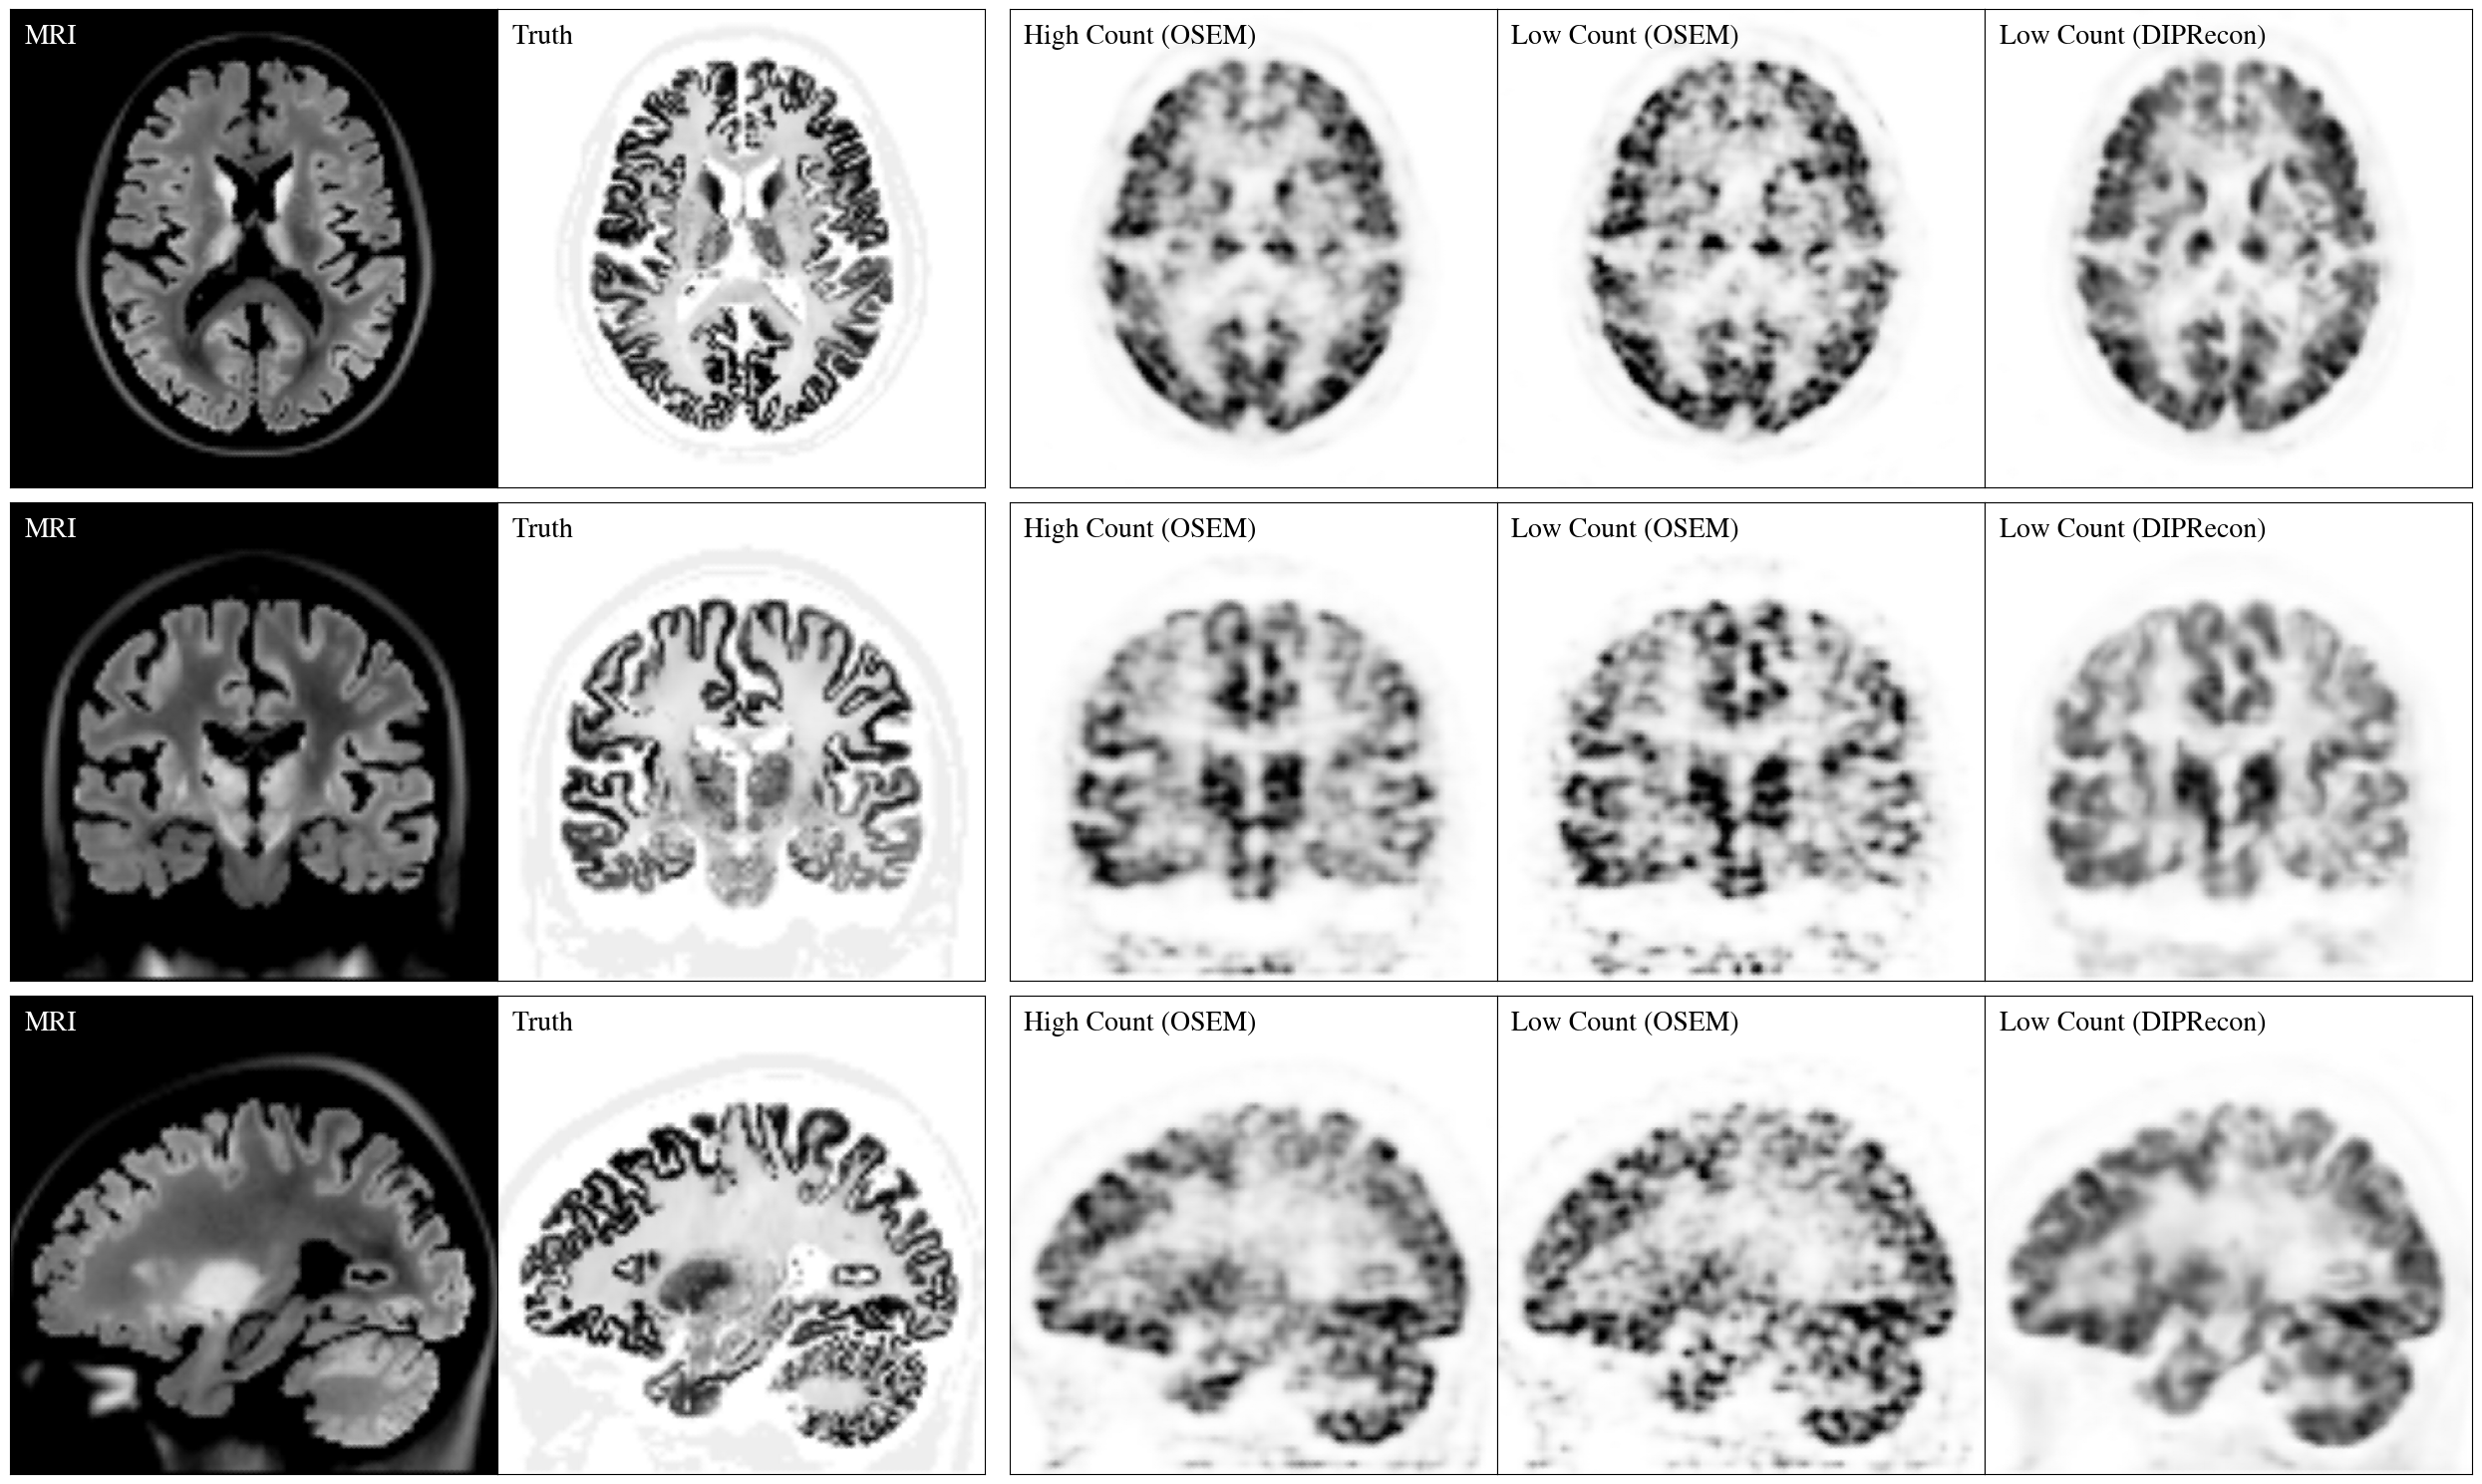

In [21]:
slc = 43
slc_cor = 64
slc_sag = 50
ww = 16
ww_axial = 7
gridspec = dict(wspace=0.0, width_ratios=[1, 1, 0.05, 1, 1, 1])
cmap = 'Greys'
text_color_pet = 'k'
vmax= 1
fig, ax = plt.subplots(3,6, figsize=(25,15), gridspec_kw=gridspec)
for i, (im, a) in enumerate(zip(ims, ax[0])):
    plt.sca(a)
    if i==2:
        plt.axis('off')
        continue
    if i==0:
        plt.pcolormesh(im[ww_axial:-ww_axial,ww_axial:-ww_axial,slc][:,::-1].T, cmap='Greys_r', vmin=120, vmax=250, shading='gouraud')
        plt.text(0.03,0.93,labels[i], fontsize=20, color='white', transform = a.transAxes)
    else:
        plt.pcolormesh(im[ww_axial:-ww_axial,ww_axial:-ww_axial,slc][:,::-1].T, cmap=cmap, shading='gouraud', vmax=vmax)
        plt.text(0.03,0.93,labels[i], fontsize=20, color=text_color_pet, transform = a.transAxes)
    #plt.axis('off')
    a.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for i, (im, a) in enumerate(zip(ims, ax[1])):
    plt.sca(a)
    if i==2:
        plt.axis('off')
        continue
    if i==0:
        plt.pcolormesh(im[ww:-ww,slc_cor].T, cmap='Greys_r', vmin=120, vmax=250, shading='gouraud')
        plt.text(0.03,0.93,labels[i], fontsize=20, color='white', transform = a.transAxes)
    else:
        plt.pcolormesh(im[ww:-ww,slc_cor].T, cmap=cmap, shading='gouraud', vmax=vmax)
        plt.text(0.03,0.93,labels[i], fontsize=20, color=text_color_pet, transform = a.transAxes)
    #plt.axis('off')
    a.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
for i, (im, a) in enumerate(zip(ims, ax[2])):
    plt.sca(a)
    if i==2:
        plt.axis('off')
        continue
    if i==0:
        plt.pcolormesh(im[slc_sag,ww:-ww].T, cmap='Greys_r', vmin=120, vmax=250, shading='gouraud')
        plt.text(0.03,0.93,labels[i], fontsize=20, color='white', transform = a.transAxes)
    else:
        plt.pcolormesh(im[slc_sag,ww:-ww].T, cmap=cmap, shading='gouraud', vmax=vmax)
        plt.text(0.03,0.93,labels[i], fontsize=20, color=text_color_pet, transform = a.transAxes)
    #plt.axis('off')
    a.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
fig.tight_layout()
plt.savefig('figures/figure4_left.jpg', dpi=300, bbox_inches='tight')

In [16]:
from pytomography.callbacks import Callback
import torch
class CRC_STD_Callback(Callback):
    def __init__(
        self,
    ) -> None:
        self.CRCs = []
        self.STDs = []
        self.biass = []
        self.stds = []
        self.biass_wm = []
        self.stds_wm = []
        self.biass_gm = []
        self.stds_gm = []
    def run(self, object: torch.tensor, n_iter: int):
        CRC = compute_CRC(object.cpu().numpy()[0])
        STD = compute_std(object.cpu().numpy()[0])
        bias, std = compute_mse(object.cpu().numpy()[0], None)
        bias_wm, std_wm = compute_mse(object.cpu().numpy()[0], white_matter_mask_aligned)
        bias_gm, std_gm = compute_mse(object.cpu().numpy()[0], grey_matter_mask_aligned)
        #print(f'CRC: {CRC}')
        #print(f'STD: {STD}')
        print(f'Bias: {np.abs(bias_wm)}')
        print(f'std: {std_wm}')
        self.CRCs.append(CRC)
        self.STDs.append(STD)
        self.biass.append(bias)
        self.stds.append(std)
        self.biass_wm.append(bias_wm)
        self.stds_wm.append(std_wm)
        self.biass_gm.append(bias_gm)
        self.stds_gm.append(std_gm)

In [17]:
with open(os.path.join(output_path, 'pet_gate_experiment', 'pet_recon1_callback'), 'rb') as f:
    cb_highcount = pickle.load(f)
with open(os.path.join(output_path, 'pet_gate_experiment', 'pet_recon2_callback'), 'rb') as f:
    cb_lowcount = pickle.load(f)
with open(os.path.join(output_path, 'pet_gate_experiment', 'pet_recon3_callback'), 'rb') as f:
    cb_dip = pickle.load(f)

In [18]:
def plot_std_bias_curve_gm(cb, iter_init=0, iter_skip=1, label=None, color='k', ls='-', marker='o'):
    plt.plot(100*np.array(cb.stds_gm[iter_init::iter_skip]), 100*np.abs(cb.biass_gm)[iter_init::iter_skip],  marker, label=label, color=color)
    plt.plot(100*np.array(cb.stds_gm[iter_init:]), 100*np.abs(cb.biass_gm)[iter_init:],  ls, color=color)
def plot_std_bias_curve_wm(cb, iter_init=0, iter_skip=1, label=None, color='k', ls='-', marker='o'):
    plt.plot(100*np.array(cb.stds_wm[iter_init::iter_skip]), 100*np.abs(cb.biass_wm)[iter_init::iter_skip],  marker, label=label, color=color)
    plt.plot(100*np.array(cb.stds_wm[iter_init:]), 100*np.abs(cb.biass_wm)[iter_init:],  ls, color=color)

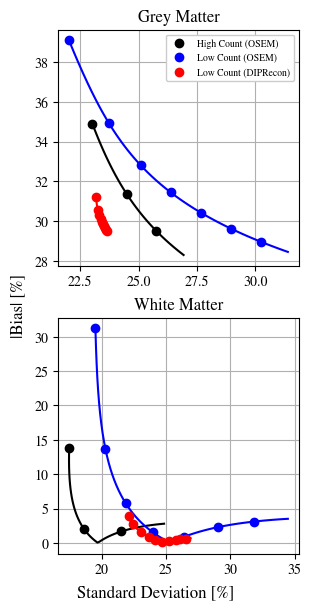

In [19]:
n = 10
fig, axes = plt.subplots(2,1,figsize=(3,6), layout='constrained')
plt.subplot(211)
plot_std_bias_curve_gm(cb_highcount, 20, 20, 'High Count (OSEM)', 'k')
plot_std_bias_curve_gm(cb_lowcount, 10, 10, 'Low Count (OSEM)', 'b')
plot_std_bias_curve_gm(cb_dip, 0, 10, 'Low Count (DIPRecon)', 'r')
plt.grid()
plt.legend(facecolor='white', framealpha=1, frameon=True, loc='upper right', fontsize=7)
plt.title('Grey Matter')
plt.subplot(212)
plot_std_bias_curve_wm(cb_highcount, 20, 20, 'High Count (OSEM)', 'k')
plot_std_bias_curve_wm(cb_lowcount, 10, 10, 'Low Count (OSEM)', 'b')
plot_std_bias_curve_wm(cb_dip, 0, 10, 'Low Count (DIPRecon)', 'r')
plt.grid()
plt.title('White Matter')
fig.supxlabel('Standard Deviation [%]')
fig.supylabel('|Bias| [%]')
plt.savefig('figures/figure4_right.jpg', dpi=300, bbox_inches='tight')